# Tutorial: Deep learning on MNIST

This tutorial demonstrates how to build a simple [feedforward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) (with one hidden layer) and train it from scratch with NumPy to recognize handwritten digit images.

Your deep learning model — one of the most basic artificial neural networks that resembles the original [multi-layer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) — will learn to classify digits from 0 to 9 from the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. The dataset contains 60,000 training and 10,000 test images and corresponding labels. Each training and test image is of size 784 (or 28x28 pixels) — this will be your input for the neural network. 

Based on the image inputs and their labels ([supervised learning](https://en.wikipedia.org/wiki/Supervised_learning)), your neural network will be trained to learn their features using forward propagation and backpropagation ([reverse-mode](https://en.wikipedia.org/wiki/Automatic_differentiation#Reverse_accumulation) differentiation). The final output of the network is a vector of 10 scores — one for each handwritten digit image. You will also evaluate how good your model is at classifying the images on the test set.

![image.png](tutorial-deep-learning-on-mnist.png)

This tutorial was adapted from the work by [Andrew Trask](https://github.com/iamtrask/Grokking-Deep-Learning) (with the author's permission).

## Prerequisites

The reader should have some knowledge of Python, NumPy array manipulation, and linear algebra. In addition, you should be familiar with main concepts of [deep learning](https://en.wikipedia.org/wiki/Deep_learning). 

To refresh the memory, you can take the [Python](https://docs.python.org/dev/tutorial/index.html) and [Linear algebra on n-dimensional arrays](https://numpy.org/doc/stable/user/tutorial-svd.html) tutorials. 

You are advised to read the [Deep learning](http://www.cs.toronto.edu/~hinton/absps/NatureDeepReview.pdf) paper published in 2015 by Yann LeCun, Yoshua Bengio, and Geoffrey Hinton, who are regarded as some of the pioneers of the field. You should also consider reading Andrew Trask's [Grokking Deep Learning](https://www.manning.com/books/grokking-deep-learning), which teaches deep learning with NumPy.

In addition to NumPy, you will be utilizing the following Python standard modules for data loading and processing: 
- [`urllib`](https://docs.python.org/3/library/urllib.html) for URL handling
- [`request`](https://docs.python.org/3/library/urllib.request.html) for URL opening
- [`gzip`](https://docs.python.org/3/library/gzip.html) for gzip file decompression
- [`pickle`](https://docs.python.org/3/library/pickle.html) to work with the pickle file format

    as well as:
- [Matplotlib](https://matplotlib.org/) for data visualization

This tutorial can be run locally in an isolated environment, such as [Virtualenv](https://virtualenv.pypa.io/en/stable/) or [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html). You can use [Jupyter Notebook or JupyterLab](https://jupyter.org/install) to run each notebook cell. Don't forget to [set up NumPy](https://numpy.org/doc/stable/user/absolute_beginners.html#installing-numpy) and [Matplotlib](https://matplotlib.org/users/installing.html#installing-an-official-release).

## Table of contents

1. Load the MNIST dataset

2. Preprocess the dataset

3. Build and train a small neural network from scratch

4. Next steps

---

## 1. Load the MNIST dataset

In this section, you will download the zipped MNIST dataset files originally stored in [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/). Then, you will transform them into 4 files of NumPy array type using built-in Python modules. Finally, you will split the arrays into training and test sets.

**1.** Define a variable to store the training/test image/label names of the MNIST dataset in a list:

In [1]:
filename = [["training_images", "train-images-idx3-ubyte.gz"],   # 60,000 training images.
            ["test_images", "t10k-images-idx3-ubyte.gz"],        # 10,000 test images.
            ["training_labels", "train-labels-idx1-ubyte.gz"],   # 60,000 training labels.
            ["test_labels", "t10k-labels-idx1-ubyte.gz"]]        # 10,000 test labels.

**2.** Download each of the 4 files in the list:

In [2]:
from urllib import request

base_url = "http://yann.lecun.com/exdb/mnist/"

for name in filename:
    print("Downloading file: " + name[1])
    request.urlretrieve(base_url + name[1], name[1])

**3.** Decompress the 4 files and create 4 [`ndarrays`](https://numpy.org/doc/stable/reference/arrays.ndarray.html), saving them into a dictionary. Each original image is of size 28x28 and neural networks normally expect a 1D vector input; therefore, you also need to reshape the images by multiplying 28 by 28 (784).

In [3]:
import gzip
import numpy as np

mnist_dataset = {}

# Images
for name in filename[:2]:
    with gzip.open(name[1], 'rb') as mnist_file:
        mnist_dataset[name[0]] = np.frombuffer(mnist_file.read(), np.uint8, offset=16).reshape(-1, 28*28)
# Labels
for name in filename[-2:]:
    with gzip.open(name[1], 'rb') as mnist_file:
        mnist_dataset[name[0]] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

**4.** Split the data into training and test sets using the standard notation of `x` for data and `y` for labels, calling the training and test set images `x_train` and `x_test`, and the labels `y_train` and `y_test`:

In [4]:
x_train, y_train, x_test, y_test = (mnist_dataset["training_images"],
                                    mnist_dataset["training_labels"],
                                    mnist_dataset["test_images"],
                                    mnist_dataset["test_labels"])

**5.** You can confirm that the shape of the image arrays is `(60000, 784)` and `(10000, 784)` for training and test sets, respectively, and the labels — `(60000,)` and `(10000,)`:

In [5]:
print('The shape of training images: {} and training labels: {}'.format(x_train.shape, y_train.shape))
print('The shape of test images: {} and test labels: {}'.format(x_test.shape, y_test.shape))

The shape of training images: (60000, 784) and training labels: (60000,)
The shape of test images: (10000, 784) and test labels: (10000,)


**6.** And you can inspect some images using Matplotlib:

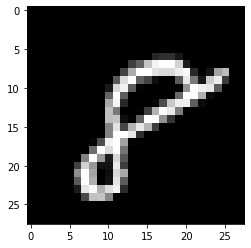

In [6]:
import matplotlib.pyplot as plt

# Take the 60,000th image (indexed at 59,999) from the training set,
# reshape from (784, ) to (28, 28) to have a valid shape for displaying purposes.
mnist_image = x_train[59999, :].reshape(28, 28)
# Set the color mapping to grayscale to have a black background.
plt.imshow(mnist_image, cmap='gray')
# Display the image.
plt.show()

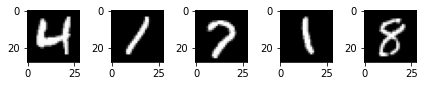

In [7]:
# Display 5 random images from the training set.
np.random.seed(0)
indices = list(np.random.randint(x_train.shape[0], size=9))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[indices[i]].reshape(28, 28), cmap='gray')
    plt.tight_layout()

> **Note:** You can also visualize a sample image as an array by printing `x_train[59999]`. Here, `59999` is your 60,000th training image sample (`0` would be your first). Your output will be quite long and should contain an array of 8-bit integers:
>
> 
> ```
> ...
>          0,   0,  38,  48,  48,  22,   0,   0,   0,   0,   0,   0,   0,
>          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
>          0,  62,  97, 198, 243, 254, 254, 212,  27,   0,   0,   0,   0,
> ...
> ```

In [8]:
# Display the label of the 60,000th image (indexed at 59,999) from the training set.
y_train[59999]

8

## 2. Preprocess the data

Neural networks can work with inputs that are in a form of tensors (multidimensional arrays) of floating-point type. When preprocessing the data, you should consider the following processes: [vectorization](https://en.wikipedia.org/wiki/Vectorization_%28mathematics%29) and [conversion to a floating-point format](https://en.wikipedia.org/wiki/Floating-point_arithmetic#Floating-point_numbers).

Since the MNIST data is already vectorized and the arrays are of `dtype` `uint8`, your next challenge is to convert them to a floating-point format, such as `float64` ([double-precision](https://en.wikipedia.org/wiki/Double-precision_floating-point_format)):

- _Normalizing_ the image data: a [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling#Application) procedure that can speed up the neural network training process by standardizing the [distribution of your input data](https://arxiv.org/pdf/1502.03167.pdf).
- _[One-hot/categorical encoding](https://en.wikipedia.org/wiki/One-hot)_ of the image labels.

In practice, you can use different types of floating-point precision depending on your goals and you can find more information about that in the [Nvidia](https://blogs.nvidia.com/blog/2019/11/15/whats-the-difference-between-single-double-multi-and-mixed-precision-computing/) and [Google Cloud](https://cloud.google.com/blog/products/ai-machine-learning/bfloat16-the-secret-to-high-performance-on-cloud-tpus) blog posts.

### Convert the image data to the floating-point format

The images data contain 8-bit integers encoded in the [0, 255] interval with color values between 0 and 255. 

You will normalize them into floating-point arrays in the [0, 1] interval by dividing them by 255.

**1.** Check that the vectorized image data has type `uint8`:

In [9]:
print('The data type of training images: {}'.format(x_train.dtype))
print('The data type of test images: {}'.format(x_test.dtype))

The data type of training images: uint8
The data type of test images: uint8


**2.** Normalize the arrays by dividing them by 255 (and thus promoting the data type from `uint8` to `float64`) and then assign the train and test image data variables — `x_train` and `x_test` — to `training_images` and `train_labels`, respectively. To make the neural network model train faster in this example, `training_images` contains only 1,000 samples out of 60,000. To learn from the entire sample size, change the `sample` variable to `60000`.

In [10]:
sample = 1000
training_images = x_train[0:sample] / 255
test_images = x_test / 255

**3.** Confirm that the image data has changed to the floating-point format:

In [11]:
print('The data type of training images: {}'.format(training_images.dtype))
print('The data type of test images: {}'.format(test_images.dtype))

The data type of training images: float64
The data type of test images: float64


> **Note:** You can also check that normalization was successful by printing `training_images[0]` in a notebook cell. Your long output should contain an array of floating-point numbers:
> 
> ```
> ...
>        0.        , 0.        , 0.01176471, 0.07058824, 0.07058824,
>        0.07058824, 0.49411765, 0.53333333, 0.68627451, 0.10196078,
>        0.65098039, 1.        , 0.96862745, 0.49803922, 0.        ,
> ...
> ```

### Convert the labels to floating point through categorical/one-hot encoding

You will use one-hot encoding to embed each digit label as an all-zero vector with `np.zeros()` and place `1` for a label index. As a result, your label data will be arrays with `1.0` (or `1.`) in the position of each image label.

Since there are 10 labels (from 0 to 9) in total, your arrays will look similar to this: 

```
array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
```

**1.** Confirm that the image label data are integers with `dtype` `uint8`:

In [12]:
print('The data type of training labels: {}'.format(y_train.dtype))
print('The data type of test labels: {}'.format(y_test.dtype))

The data type of training labels: uint8
The data type of test labels: uint8


**2.** Define a function that performs one-hot encoding on arrays:

In [13]:
def one_hot_encoding(labels, dimension=10):
    # Define a one-hot variable for an all-zero vector 
    # with 10 dimensions (number labels from 0 to 9).
    one_hot_labels = (labels[..., None] == np.arange(dimension)[None])
    # Return one-hot encoded labels.
    return one_hot_labels.astype(np.float64)

**3.** Encode the labels and assign the values to new variables:

In [14]:
training_labels = one_hot_encoding(y_train)
test_labels = one_hot_encoding(y_test)

**4.** Check that the data type has changed to floating point:

In [15]:
print('The data type of training labels: {}'.format(training_labels.dtype))
print('The data type of test labels: {}'.format(test_labels.dtype))

The data type of training labels: float64
The data type of test labels: float64


**5.** Examine a few encoded labels:

In [16]:
print(training_labels[0])
print(training_labels[1])
print(training_labels[2])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


...and compare to the originals:

In [17]:
print(y_train[0])
print(y_train[1])
print(y_train[2])

5
0
4


You have finished preparing the dataset.

## 3. Build and train a small neural network from scratch

In this section you will familiarize yourself with some high-level concepts of the basic building blocks of a deep learning model. You can refer to the original [Deep learning](http://www.cs.toronto.edu/~hinton/absps/NatureDeepReview.pdf) research publication for more information.

Afterwards, you will construct the building blocks of a simple deep learning model in Python and NumPy and train it to learn to identify handwritten digits from the MNIST dataset with a certain level of accuracy.

### Neural network building blocks with NumPy

- _Layers_: These building blocks work as data filters — they process data and learn representations from inputs to better predict the target outputs.

    You will use 1 hidden layer in your model to pass the inputs forward (_forward propagation_) and propagate the gradients/error derivatives of a loss function backward (_backpropagation_). These are input, hidden and output layers.
    
    In the hidden (middle) and output (last) layers, the neural network model will compute the weighted sum of inputs. To compute this process, you will use NumPy's matrix multiplication function (the "dot multiply" or `np.dot(layer, weights)`).

    > **Note:** For simplicity, the bias term is omitted in this example (there is no `np.dot(layer, weights) + bias`).

- _Weights_: These are important adjustable parameters that the neural network fine-tunes by forward and backward propagating the data. They are optimized through a process called [gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Before the model training starts, the weights are randomly initialized with NumPy's `np.random.random()` function.
    
    The optimal weights should produce the highest prediction accuracy and the lowest error on the training and test sets. 

- _Activation function_: Deep learning models are capable of determining non-linear relationships between inputs and outputs and these [non-linear functions](https://en.wikipedia.org/wiki/Activation_function) are usually applied to the output of each layer.

    You will use a [rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) to the hidden layer's output (for example, `relu(np.dot(layer, weights))`.

- _Regularization_: This [technique](https://en.wikipedia.org/wiki/Regularization_(mathematics)) helps prevent the neural network model from [overfitting](https://en.wikipedia.org/wiki/Overfitting). 

    In this example, you will use a method called dropout — [dilution](https://en.wikipedia.org/wiki/Dilution_(neural_networks)) — that randomly sets a number of features in a layer to 0s. You will define it with NumPy's `np.random.randint()` function and apply it to the hidden layer of the network.

- _Loss function_: The computation determines the quality of predictions by comparing the image labels (the truth) with the predicted values in the final layer's output.

    For simplicity, you will use a basic total squared error using NumPy's `np.sum()` function (for example, `np.sum((final_layer_output - image_labels) ** 2)`).

- _Accuracy_: This metric measures the accuracy of the network's ability to predict on the data it hasn't seen.

### Model architecture and training summary

Here is a summary of the neural network model architecture and the training process:

![image.png](tutorial-deep-learning-on-mnist.png)

- _The input layer_: 

    It is the input for the network — the previously preprocessed data that is loaded from `training_images` into `layer_0`.

- _The hidden (middle) layer_: 

    `layer_1` takes the output from the previous layer and performs matrix-multiplication of the input by weights (`weights_1`) with NumPy's `np.dot()`).

    Then, this output is passed through the ReLU activation function for non-linearity and then dropout is applied to help with overfitting.

- _The output (last) layer_: 

    `layer_2` ingests the output from `layer_1` and repeats the same "dot multiply" process with `weights_2`.

    The final output returns 10 scores for each of the 0-9 digit labels. The network model ends with a size 10 layer — a 10-dimensional vector.

- _Forward propagation, backpropagation, training loop_: 

    In the beginning of model training, your network randomly initializes the weights and feeds the input data forward through the hidden and output layers. This process is the forward pass or forward propagation. 
    
    Then, the network propagates the "signal" from the loss function back through the hidden layer and adjusts the weights values with the help of the learning rate parameter (more on that later). 
    
> **Note:** In more technical terms, you: 
>    
>    1. Measure the error by comparing the real label of an image (the truth) with the prediction of the model.
>    2. Differentiate the loss function.
>    3. Ingest the [gradients](https://en.wikipedia.org/wiki/Gradient) with the respect to the output, and backpropagate them with the respect to the inputs through the layer(s). 
>    
>    Since the network contains tensor operations and weight matrices, backpropagation uses the [chain rule](https://en.wikipedia.org/wiki/Chain_rule).
>
>    With each iteration (epoch) of the neural network training, this forward and backward propagation cycle adjusts the weights, which is reflected in the accuracy and error metrics. As you train the model, your goal is to minimize the error and maximize the accuracy on the training data, where the model learns from, as well as the test data, where you evaluate the model.

### Compose the model and begin training and testing it

Having covered the main deep learning concepts and the neural network architecture, let's write the code.

**1.** For reproducibility, initialize a random seed with `np.random.seed()`:

In [18]:
np.random.seed(1)

**2.** For the hidden layer, define the ReLU activation function for forward propagation and ReLU's derivative that will be used during backpropagation:

In [19]:
# Define ReLU that returns the input if it's positive and 0 otherwise.
def relu (x):
    return (x>=0) * x

# Set up a derivative of the ReLU function that returns 1 for a positive input 
# and 0 otherwise.
def relu2deriv(output):
    return output >= 0

**3.** Set certain default values of [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)), such as:

    - [_Learning rate_](https://en.wikipedia.org/wiki/Learning_rate): `learning_rate` — helps limit the magnitude of weight updates to prevent them from overcorrecting.
    - _Epochs (iterations)_: `epochs` — the number of complete passes — forward and backward propagations — of the data through the network. This parameter can positively or negatively affect the results. The higher the iterations, the longer the learning process may take.
    - _Size of the hidden (middle) layer in a network_: `hidden_size` — different sizes of the hidden layer can affect the results during training and testing.
    - _Size of the input:_ `pixels_per_image` — you have established that the image input is 784 (28x28) (in pixels).
    - _Number of labels_: `num_labels` — indicates the output number for the output layer where the predictions occur for 10 (0 to 9) handwritten digit labels.

In [20]:
learning_rate = 0.005
epochs = 100
hidden_size = 100
pixels_per_image = 784
num_labels = 10

**4.** Initialize the weight vectors that will be used in the hidden and output layers with `np.random.random()`:

In [21]:
weights_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

**5.** Set up the neural network's learning experiment with a training loop and start the training process:

In [22]:
# To store training and test set losses and accurate predictions
# for visualization.
store_training_loss = []
store_training_accurate_pred = []
store_test_loss = []
store_test_accurate_pred = []

# This is a training loop.
# Run the learning experiment for a defined number of epochs (iterations).
for j in range(epochs):
    # Set the initial loss/error and the number of accurate predictions to zero.
    training_loss = 0.0
    training_accurate_predictions = 0
    
    # For all images in the training set, perform a forward pass
    # and backpropagation and adjust the weights accordingly.
    for i in range(len(training_images)):
        # Forward propagation/forward pass:
        # 1. The input layer:
        #    Initialize the training image data as inputs.
        layer_0 = training_images[i]
        # 2. The hidden layer:
        #    Take in the training image data into the middle layer by 
        #    matrix-multiplying it by randomly initialized weights. 
        layer_1 = np.dot(layer_0, weights_1)
        # 3. Pass the hidden layer's output through the ReLU activation function.
        layer_1 = relu(layer_1)
        # 4. Define the dropout function for regularization.
        dropout_mask = np.random.randint(0, high=2, size=layer_1.shape)
        # 5. Apply dropout to the hidden layer's output.
        layer_1 *= dropout_mask * 2
        # 6. The output layer:
        #    Ingest the output of the middle layer into the the final layer
        #    by matrix-multiplying it by randomly initialized weights.
        #    Produce a 10-dimension vector with 10 scores.
        layer_2 = np.dot(layer_1, weights_2)

        # Backpropagation/backward pass:
        # 1. Measure the training error (loss function) between the actual
        #    image labels (the truth) and the prediction by the model.
        training_loss += np.sum((training_labels[i] - layer_2) ** 2)
        # 2. Increment the accurate prediction count.
        training_accurate_predictions += int(np.argmax(layer_2) == np.argmax(training_labels[i]))
        # 3. Differentiate the loss function/error.
        layer_2_delta = (training_labels[i] - layer_2)
        # 4. Propagate the gradients of the loss function back through the hidden layer.
        layer_1_delta = np.dot(weights_2, layer_2_delta) * relu2deriv(layer_1)
        # 5. Apply the dropout to the gradients.
        layer_1_delta *= dropout_mask
        # 6. Update the weights for the middle and input layers
        #    by multiplying them by the learning rate and the gradients.
        weights_1 += learning_rate * np.outer(layer_0, layer_1_delta)
        weights_2 += learning_rate * np.outer(layer_1, layer_2_delta)
    
    # Store training set losses and accurate predictions.
    store_training_loss.append(training_loss)
    store_training_accurate_pred.append(training_accurate_predictions)

    # Evaluate on the test set:
    # 1. Set the initial error and the number of accurate predictions to zero.
    test_loss = 0.0
    test_accurate_predictions = 0
    
    # 2. Start testing the model by evaluating on the test image dataset.
    for i in range(len(test_images)):
        # 1. Pass the test images through the input layer.
        layer_0 = test_images[i]
        # 2. Compute the weighted sum of the test image inputs in and
        #    pass the hidden layer's output through ReLU.
        layer_1 = relu(np.dot(layer_0, weights_1))
        # 3. Compute the weighted sum of the hidden layer's inputs.
        #    Produce a 10-dimensional vector with 10 scores.
        layer_2 = np.dot(layer_1, weights_2)

        # 4. Measure the error between the actual label (truth) and prediction values.
        test_loss += np.sum((test_labels[i] - layer_2) ** 2)
        # 5. Increment the accurate prediction count.
        test_accurate_predictions += int(np.argmax(layer_2) == np.argmax(test_labels[i]))

    # Store test set losses and accurate predictions.
    store_test_loss.append(test_loss)
    store_test_accurate_pred.append(test_accurate_predictions)

    # 3. Display the error and accuracy metrics in the output.
    print("\n" + \
          "Epoch: " + str(j) + \
          " Training set error:" + str(training_loss/ float(len(training_images)))[0:5] +\
          " Training set accuracy:" + str(training_accurate_predictions/ float(len(training_images))) +\
          " Test set error:" + str(test_loss/ float(len(test_images)))[0:5] +\
          " Test set accuracy:" + str(test_accurate_predictions/ float(len(test_images))))


Epoch: 0 Training set error:0.891 Training set accuracy:0.413 Test set error:0.641 Test set accuracy:0.6333



Epoch: 1 Training set error:0.650 Training set accuracy:0.62 Test set error:0.578 Test set accuracy:0.6835



Epoch: 2 Training set error:0.597 Training set accuracy:0.669 Test set error:0.548 Test set accuracy:0.7125



Epoch: 3 Training set error:0.565 Training set accuracy:0.686 Test set error:0.530 Test set accuracy:0.7367



Epoch: 4 Training set error:0.547 Training set accuracy:0.712 Test set error:0.491 Test set accuracy:0.7608



Epoch: 5 Training set error:0.515 Training set accuracy:0.739 Test set error:0.481 Test set accuracy:0.7727



Epoch: 6 Training set error:0.514 Training set accuracy:0.727 Test set error:0.476 Test set accuracy:0.7855



Epoch: 7 Training set error:0.499 Training set accuracy:0.73 Test set error:0.462 Test set accuracy:0.7811



Epoch: 8 Training set error:0.483 Training set accuracy:0.759 Test set error:0.455 Test set accuracy:0.7903



Epoch: 9 Training set error:0.469 Training set accuracy:0.754 Test set error:0.464 Test set accuracy:0.7869



Epoch: 10 Training set error:0.472 Training set accuracy:0.764 Test set error:0.458 Test set accuracy:0.787



Epoch: 11 Training set error:0.460 Training set accuracy:0.779 Test set error:0.439 Test set accuracy:0.7984



Epoch: 12 Training set error:0.465 Training set accuracy:0.793 Test set error:0.451 Test set accuracy:0.805



Epoch: 13 Training set error:0.444 Training set accuracy:0.803 Test set error:0.441 Test set accuracy:0.8065



Epoch: 14 Training set error:0.458 Training set accuracy:0.786 Test set error:0.441 Test set accuracy:0.8032



Epoch: 15 Training set error:0.446 Training set accuracy:0.794 Test set error:0.435 Test set accuracy:0.8097



Epoch: 16 Training set error:0.437 Training set accuracy:0.795 Test set error:0.425 Test set accuracy:0.8155



Epoch: 17 Training set error:0.423 Training set accuracy:0.82 Test set error:0.419 Test set accuracy:0.814



Epoch: 18 Training set error:0.442 Training set accuracy:0.812 Test set error:0.430 Test set accuracy:0.8156



Epoch: 19 Training set error:0.440 Training set accuracy:0.818 Test set error:0.428 Test set accuracy:0.8103



Epoch: 20 Training set error:0.430 Training set accuracy:0.809 Test set error:0.415 Test set accuracy:0.8133



Epoch: 21 Training set error:0.436 Training set accuracy:0.801 Test set error:0.435 Test set accuracy:0.8042



Epoch: 22 Training set error:0.425 Training set accuracy:0.819 Test set error:0.427 Test set accuracy:0.8008



Epoch: 23 Training set error:0.427 Training set accuracy:0.813 Test set error:0.432 Test set accuracy:0.8127



Epoch: 24 Training set error:0.431 Training set accuracy:0.806 Test set error:0.429 Test set accuracy:0.8061



Epoch: 25 Training set error:0.434 Training set accuracy:0.816 Test set error:0.428 Test set accuracy:0.8121



Epoch: 26 Training set error:0.426 Training set accuracy:0.831 Test set error:0.430 Test set accuracy:0.8084



Epoch: 27 Training set error:0.432 Training set accuracy:0.805 Test set error:0.427 Test set accuracy:0.8065



Epoch: 28 Training set error:0.411 Training set accuracy:0.831 Test set error:0.431 Test set accuracy:0.7985



Epoch: 29 Training set error:0.403 Training set accuracy:0.83 Test set error:0.424 Test set accuracy:0.8096



Epoch: 30 Training set error:0.415 Training set accuracy:0.811 Test set error:0.421 Test set accuracy:0.8114



Epoch: 31 Training set error:0.424 Training set accuracy:0.813 Test set error:0.428 Test set accuracy:0.8043



Epoch: 32 Training set error:0.411 Training set accuracy:0.83 Test set error:0.422 Test set accuracy:0.8155



Epoch: 33 Training set error:0.423 Training set accuracy:0.802 Test set error:0.420 Test set accuracy:0.8109



Epoch: 34 Training set error:0.417 Training set accuracy:0.816 Test set error:0.417 Test set accuracy:0.8123



Epoch: 35 Training set error:0.410 Training set accuracy:0.824 Test set error:0.430 Test set accuracy:0.8064



Epoch: 36 Training set error:0.417 Training set accuracy:0.826 Test set error:0.422 Test set accuracy:0.808



Epoch: 37 Training set error:0.416 Training set accuracy:0.835 Test set error:0.425 Test set accuracy:0.8099



Epoch: 38 Training set error:0.411 Training set accuracy:0.83 Test set error:0.419 Test set accuracy:0.8128



Epoch: 39 Training set error:0.409 Training set accuracy:0.827 Test set error:0.420 Test set accuracy:0.8044



Epoch: 40 Training set error:0.413 Training set accuracy:0.827 Test set error:0.419 Test set accuracy:0.8112



Epoch: 41 Training set error:0.410 Training set accuracy:0.85 Test set error:0.420 Test set accuracy:0.8102



Epoch: 42 Training set error:0.405 Training set accuracy:0.833 Test set error:0.419 Test set accuracy:0.8165



Epoch: 43 Training set error:0.409 Training set accuracy:0.824 Test set error:0.415 Test set accuracy:0.8196



Epoch: 44 Training set error:0.396 Training set accuracy:0.83 Test set error:0.415 Test set accuracy:0.8181



Epoch: 45 Training set error:0.401 Training set accuracy:0.85 Test set error:0.425 Test set accuracy:0.8083



Epoch: 46 Training set error:0.412 Training set accuracy:0.836 Test set error:0.416 Test set accuracy:0.8051



Epoch: 47 Training set error:0.404 Training set accuracy:0.844 Test set error:0.424 Test set accuracy:0.8059



Epoch: 48 Training set error:0.399 Training set accuracy:0.841 Test set error:0.417 Test set accuracy:0.8137



Epoch: 49 Training set error:0.404 Training set accuracy:0.841 Test set error:0.416 Test set accuracy:0.8151



Epoch: 50 Training set error:0.392 Training set accuracy:0.836 Test set error:0.409 Test set accuracy:0.8133



Epoch: 51 Training set error:0.398 Training set accuracy:0.838 Test set error:0.412 Test set accuracy:0.8121



Epoch: 52 Training set error:0.388 Training set accuracy:0.844 Test set error:0.417 Test set accuracy:0.8171



Epoch: 53 Training set error:0.399 Training set accuracy:0.831 Test set error:0.417 Test set accuracy:0.8101



Epoch: 54 Training set error:0.393 Training set accuracy:0.842 Test set error:0.411 Test set accuracy:0.8165



Epoch: 55 Training set error:0.387 Training set accuracy:0.847 Test set error:0.415 Test set accuracy:0.8177



Epoch: 56 Training set error:0.390 Training set accuracy:0.842 Test set error:0.416 Test set accuracy:0.8164



Epoch: 57 Training set error:0.391 Training set accuracy:0.839 Test set error:0.404 Test set accuracy:0.8178



Epoch: 58 Training set error:0.383 Training set accuracy:0.846 Test set error:0.411 Test set accuracy:0.8126



Epoch: 59 Training set error:0.394 Training set accuracy:0.852 Test set error:0.410 Test set accuracy:0.8164



Epoch: 60 Training set error:0.402 Training set accuracy:0.836 Test set error:0.412 Test set accuracy:0.8236



Epoch: 61 Training set error:0.390 Training set accuracy:0.848 Test set error:0.414 Test set accuracy:0.823



Epoch: 62 Training set error:0.386 Training set accuracy:0.846 Test set error:0.405 Test set accuracy:0.8168



Epoch: 63 Training set error:0.390 Training set accuracy:0.859 Test set error:0.409 Test set accuracy:0.8217



Epoch: 64 Training set error:0.389 Training set accuracy:0.85 Test set error:0.409 Test set accuracy:0.8186



Epoch: 65 Training set error:0.393 Training set accuracy:0.847 Test set error:0.402 Test set accuracy:0.8182



Epoch: 66 Training set error:0.380 Training set accuracy:0.843 Test set error:0.407 Test set accuracy:0.8111



Epoch: 67 Training set error:0.386 Training set accuracy:0.846 Test set error:0.419 Test set accuracy:0.813



Epoch: 68 Training set error:0.391 Training set accuracy:0.845 Test set error:0.410 Test set accuracy:0.8105



Epoch: 69 Training set error:0.400 Training set accuracy:0.856 Test set error:0.412 Test set accuracy:0.7985



Epoch: 70 Training set error:0.383 Training set accuracy:0.857 Test set error:0.412 Test set accuracy:0.8033



Epoch: 71 Training set error:0.380 Training set accuracy:0.844 Test set error:0.411 Test set accuracy:0.8115



Epoch: 72 Training set error:0.388 Training set accuracy:0.853 Test set error:0.411 Test set accuracy:0.8049



Epoch: 73 Training set error:0.374 Training set accuracy:0.856 Test set error:0.415 Test set accuracy:0.7861



Epoch: 74 Training set error:0.393 Training set accuracy:0.844 Test set error:0.412 Test set accuracy:0.8051



Epoch: 75 Training set error:0.389 Training set accuracy:0.85 Test set error:0.415 Test set accuracy:0.8124



Epoch: 76 Training set error:0.388 Training set accuracy:0.857 Test set error:0.420 Test set accuracy:0.8012



Epoch: 77 Training set error:0.384 Training set accuracy:0.851 Test set error:0.420 Test set accuracy:0.7946



Epoch: 78 Training set error:0.388 Training set accuracy:0.851 Test set error:0.422 Test set accuracy:0.7995



Epoch: 79 Training set error:0.383 Training set accuracy:0.852 Test set error:0.407 Test set accuracy:0.8076



Epoch: 80 Training set error:0.386 Training set accuracy:0.854 Test set error:0.410 Test set accuracy:0.8054



Epoch: 81 Training set error:0.378 Training set accuracy:0.863 Test set error:0.410 Test set accuracy:0.8109



Epoch: 82 Training set error:0.364 Training set accuracy:0.865 Test set error:0.408 Test set accuracy:0.7994



Epoch: 83 Training set error:0.364 Training set accuracy:0.859 Test set error:0.395 Test set accuracy:0.8164



Epoch: 84 Training set error:0.378 Training set accuracy:0.854 Test set error:0.410 Test set accuracy:0.8116



Epoch: 85 Training set error:0.388 Training set accuracy:0.844 Test set error:0.406 Test set accuracy:0.8122



Epoch: 86 Training set error:0.367 Training set accuracy:0.859 Test set error:0.404 Test set accuracy:0.8109



Epoch: 87 Training set error:0.380 Training set accuracy:0.847 Test set error:0.410 Test set accuracy:0.8092



Epoch: 88 Training set error:0.369 Training set accuracy:0.859 Test set error:0.422 Test set accuracy:0.7978



Epoch: 89 Training set error:0.362 Training set accuracy:0.865 Test set error:0.417 Test set accuracy:0.7887



Epoch: 90 Training set error:0.376 Training set accuracy:0.868 Test set error:0.411 Test set accuracy:0.8144



Epoch: 91 Training set error:0.365 Training set accuracy:0.851 Test set error:0.411 Test set accuracy:0.7982



Epoch: 92 Training set error:0.373 Training set accuracy:0.86 Test set error:0.410 Test set accuracy:0.805



Epoch: 93 Training set error:0.366 Training set accuracy:0.864 Test set error:0.397 Test set accuracy:0.8177



Epoch: 94 Training set error:0.367 Training set accuracy:0.872 Test set error:0.402 Test set accuracy:0.8112



Epoch: 95 Training set error:0.364 Training set accuracy:0.853 Test set error:0.404 Test set accuracy:0.8012



Epoch: 96 Training set error:0.365 Training set accuracy:0.867 Test set error:0.405 Test set accuracy:0.8023



Epoch: 97 Training set error:0.367 Training set accuracy:0.861 Test set error:0.408 Test set accuracy:0.7954



Epoch: 98 Training set error:0.363 Training set accuracy:0.859 Test set error:0.409 Test set accuracy:0.7974



Epoch: 99 Training set error:0.365 Training set accuracy:0.867 Test set error:0.407 Test set accuracy:0.7954


The training process may take many minutes, depending on a number of factors, such as the processing power of the machine you are running the experiment on and the number of epochs. To reduce the waiting time, you can change the epoch (iteration) variable from 100 to a lower number, reset the runtime (which will reset the weights), and run the notebook cells again.

Let's visualize the training and test set errors and accuracy:

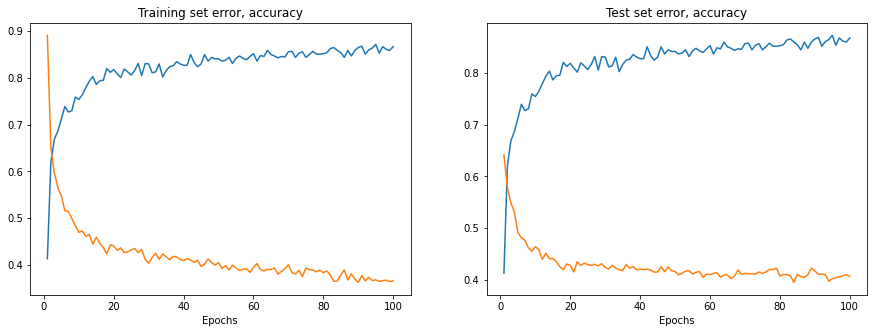

In [23]:
# The training set metrics.
y_training_error = [store_training_loss[i]/float(len(training_images)) for i in range(len(store_training_loss))]
x_training_error = range(1, len(store_training_loss)+1)
y_training_accuracy = [store_training_accurate_pred[i]/ float(len(training_images)) for i in range(len(store_training_accurate_pred))]
x_training_accuracy = range(1, len(store_training_accurate_pred)+1)

# The test set metrics.
y_test_error = [store_test_loss[i]/float(len(test_images)) for i in range(len(store_test_loss))]
x_test_error = range(1, len(store_test_loss)+1)
y_test_accuracy = [store_training_accurate_pred[i]/ float(len(training_images)) for i in range(len(store_training_accurate_pred))]
x_test_accuracy = range(1, len(store_test_accurate_pred)+1)

# Display the plots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('Training set error, accuracy')
axes[0].plot(x_training_accuracy, y_training_accuracy, label = "Training set accuracy")
axes[0].plot(x_training_error, y_training_error, label = "Training set error")
axes[0].set_xlabel("Epochs")
axes[1].set_title('Test set error, accuracy')
axes[1].plot(x_test_accuracy, y_test_accuracy, label = "Test set accuracy")
axes[1].plot(x_test_error, y_test_error, label = "Test set error")
axes[1].set_xlabel("Epochs")
plt.show()

The accuracy rates that your model reaches during training and testing may be somewhat plausible but you may also find the error rates to be quite high. 

To reduce the error during training and testing, you can consider changing the simple loss function to, for example, categorical [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy). Other possible solutions are discussed below.

## Next steps

You have learned how to build and train a simple feed-forward neural network from scratch using just NumPy to classify handwritten MNIST digits.

To further enhance and optimize your neural network model, you can consider one of a mixture of the following:
- Increase the training sample size from 1,000 to a higher number (up to 60,000).
- Use [mini-batches and reduce the learning rate](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf).
- Alter the architecture by introducing more hidden layers to make the network [deeper](https://en.wikipedia.org/wiki/Deep_learning).
- Combine the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss function with a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation function in the last layer.
- Introduce convolutional layers: replace the feedforward network with a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) architecture.
- Use a higher epoch size to train longer and add more regularization techniques, such as [early stopping](https://en.wikipedia.org/wiki/Early_stopping), to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting).
- Introduce a [validation set](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets) for an unbiased valuation of the model fit.
- Apply [batch normalization](https://en.wikipedia.org/wiki/Batch_normalization) for faster and more stable training.
- Tune other parameters, such as the learning rate and hidden layer size.

Finally, you can go beyond NumPy with specialized frameworks and APIs — such as [TensorFlow](https://www.tensorflow.org/guide/tf_numpy?hl=el), [PyTorch](https://pytorch.org/docs/stable/generated/torch.from_numpy.html), Swift for TensorFlow (with [Python interoperability](https://www.tensorflow.org/swift/tutorials/python_interoperability)), and [JAX](https://github.com/google/jax) — that support NumPy, have built-in [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), and are designed for high-performance numerical computing and machine learning.

(Credit to [hsjeong5](https://github.com/hsjeong5/MNIST-for-Numpy) for demonstrating how to download MNIST without the use of external libraries.)